# Smart cluster labeling using Generative AI

Author: abdul.jilani@datarobot.com 

## Summary

DataRobot has democratized unsupervised learning by allowing you to run clustering on datasets with minimal effort and risk with guardrails and smart visualizations. You can build segmentation models on any kind of dataset they can conjure. Once the segments/clusters are built, DataRobot provides cluster level insights which can be used to understand each cluster/segment further. Generally, cluster/segment analysis requires a subject matter expert to be able to understand and label the segment. However, with the advancement of Generative AI, users without subject matter expertise can leverage LLMs to provide last mile analytics on clustering or segmentation models. 

This accelerator shows how you can use <a href='https://app.datarobot.com/docs/modeling/analyze-models/understand/cluster-insights.html'>cluster insights</a> provided by DataRobot with ChatGPT to provide business- or domain-specific labels to the clusters using OpenAI and DataRobot APIs.

- The dataset used in this notebook is the 10K diabetes dataset that contains <a href='https://s3.amazonaws.com/datarobot_data_science/test_data/10k_diabetes.xlsx'>diabetic patient readmission data.</a>
- The outcome is to use generative AI models to perform cluster analysis and label the clusters built by machine learning models.
- This accelerator assumes that you have an API key for OpenAI systems. This method can be used for generative text AI models similar to GPT-3.

## Setup

### Import libraries

Use the following cells to import the required libraries and configure connections to DataRobot and Azure OpenAI.

In [1]:
import json
import warnings

import datarobot as dr
import openai
import pandas as pd
import yaml

warnings.filterwarnings("ignore")

### Connect to DataRobot and OpenAI

Read more about different options for [connecting to DataRobot from the Python client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [17]:
with open("./settings.yaml", "r") as stream:
    config = yaml.safe_load(stream)
print("OpenAI Key --> ", config["openai_key"])
print("DataRobot Endpoint --> ", config["endpoint"])
print("DataRobot API Token --> ", config["token"])

OpenAI Key -->  Add OpenAI Key in settings.yaml file
DataRobot Endpoint -->  https://app.datarobot.com/api/v2
DataRobot API Token -->  Add DataRobot API Token in settings.yaml file


In [3]:
openai.api_key = config["openai_key"]
dr.Client(endpoint=config["endpoint"], token=config["token"])

### Prompt completion
This demo uses Openai's chatGPT but the approach can be used on similar LLM models. The prompt structure and completion functions are inspired from Andrew Ng's course on <a href='https://www.deeplearning.ai/short-courses/chatgpt-prompt-engineering-for-developers/'>Prompt Engineering.</a>

In [4]:
max_token_size = 4097


def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    return response.choices[0].message["content"]

### Import data
Ingest the dataset for clustering. Drop the target feature as it may overpower the clusters.

In [2]:
diabetes_dataset = pd.read_excel(
    "https://s3.amazonaws.com/datarobot_data_science/test_data/10k_diabetes.xlsx"
)
diabetes_dataset.drop(columns=["readmitted"], inplace=True)
diabetes_dataset.shape

(10000, 50)

## Modeling

### Create a DataRobot clustering project

The following cell creates a projects and starts Autopilot.

In [3]:
project = dr.Project.create(diabetes_dataset, project_name="unsupervised clustering")
project.analyze_and_model(
    unsupervised_mode=True,
    mode=dr.enums.AUTOPILOT_MODE.COMPREHENSIVE,
    unsupervised_type=dr.enums.UnsupervisedTypeEnum.CLUSTERING,
)
project.wait_for_autopilot()

In progress: 6, queued: 0 (waited: 0s)
In progress: 6, queued: 0 (waited: 1s)
In progress: 6, queued: 0 (waited: 3s)
In progress: 6, queued: 0 (waited: 4s)
In progress: 6, queued: 0 (waited: 6s)
In progress: 6, queued: 0 (waited: 9s)
In progress: 6, queued: 0 (waited: 13s)
In progress: 6, queued: 0 (waited: 21s)
In progress: 6, queued: 0 (waited: 35s)
In progress: 0, queued: 0 (waited: 56s)


### Model selection

Select the model to analyse and rename the generated clusters.

In [4]:
model = dr.ClusteringModel.get(project.id, project.get_models(order_by="metric")[-1].id)
print("{} clusters found".format(model.n_clusters))

7 clusters found


### Cluster insights

Compute and ingest cluster insights from DataRobot models.

In [7]:
insights = model.compute_insights()
len(insights)

50

Select a cap on the top insights to use for cluster labeling. This will allow users to avoid sending too many tokens to the LLM and confusing it.

In [8]:
top_n = 5
insights_top = insights[0:top_n]
# insights_top = insights[2:top_n]
len(insights_top)

5

### Cluster summary
The below function generates Clusters' summary to send to the LLM model via prompt engineering.

In [9]:
def get_cluster_info(insights_list, top_n_values=3):
    df_results = pd.DataFrame()
    for insight in insights_list:
        ci = insight
        ci_ind = ci.insights[0]
        for cluster in ci_ind["per_cluster"]:
            if (insight.feature_type == "text") | (insight.feature_type == "categorical"):
                temp_df = (
                    pd.DataFrame(cluster["per_value_statistics"])
                    .sort_values("importance", ascending=False)
                    .head(5)
                )
                temp_df = temp_df.iloc[:, 0:2]
                temp_df.columns = ["value", "stat"]
                temp_df["cluster"] = cluster["cluster_name"]
                temp_df["feature"] = insight.feature_name
                temp_df["feature_type"] = insight.feature_type
                temp_df["feature_impact"] = insight.feature_impact
            elif insight.feature_type == "numeric":
                temp_df = pd.DataFrame([cluster])
                temp_df["value"] = insight.feature_name
                temp_df = temp_df[["value", "statistic"]].rename(columns={"statistic": "stat"})
                temp_df["cluster"] = cluster["cluster_name"]
                temp_df["feature"] = insight.feature_name
                temp_df["feature_type"] = insight.feature_type
                temp_df["feature_impact"] = insight.feature_impact
            df_results = pd.concat([df_results, temp_df.head(top_n_values)], axis=0)
    df_num_insights = df_results[df_results.feature_type == "numeric"]
    df_cat_insights = df_results[df_results.feature_type != "numeric"]
    df_cat = df_cat_insights.groupby(["cluster"], as_index=False)["value"].agg({"value": ", ".join})
    df_num_insights["num_insight"] = (
        "Average " + df_num_insights["value"] + " is " + df_num_insights["stat"].apply(str)
    )
    df_num = df_num_insights.groupby(["cluster"], as_index=False)["num_insight"].agg(
        {"num_insight": ", ".join}
    )
    df_full = df_cat.merge(df_num, on="cluster")
    df_full["final"] = (
        df_full["cluster"] + ": " + df_full["value"] + "," + df_full["num_insight"] + "; "
    )
    return " ".join(df_full["final"].values.tolist())

In [10]:
cluster_info = get_cluster_info(insights_top, 3)
cluster_info

'Cluster 1: liveborn, outcome, delivery, mellitus, anomalies, mother, accompanying, healthy, person,Average time_in_hospital is 3.0102249488752557, Average number_diagnoses is 4.875937286980232;  Cluster 2: esophagus, acromegaly, gigantism, inguinal, dementia, senile, cysts, amblyopia, bleeding,Average time_in_hospital is 3.8177290836653386, Average number_diagnoses is 7.886454183266932;  Cluster 3: postmyocardial, insomnia, organic, coronary, native, vessel, postmyocardial, syndrome, infarction,Average time_in_hospital is 4.021739130434782, Average number_diagnoses is 6.911764705882353;  Cluster 4: mellitus, stated, ii, inertia, uterine, nontoxic, carcinoma, cystic, deformity,Average time_in_hospital is 3.371548117154812, Average number_diagnoses is 5.773221757322176;  Cluster 5: iv, stage, through, alkaloids, opium, disseminated, pelvis, hereditary, infiltrative,Average time_in_hospital is 4.708683473389356, Average number_diagnoses is 7.927170868347339;  Cluster 6: 19, adult, body, 

### Prompt function

The below functions uses the Cluster Summary and requests LLM model to label the clusters. The parameter <b>"label_type"</b> can be used to tweak the flavor of the cluster labels.

In [12]:
def get_cluster_names(cluster_info, label_types="human friendly and descriptive"):
    prompt = (
        'you are an business analyst. You have run a clustering model and following text in double quotes shows the cluster level values."'
        + cluster_info
        + "”. Please provide "
        + label_types
        + " cluster names for each cluster. Output format is json with fields cluster description, cluster name, cluster id."
    )
    response = get_completion(prompt)
    return prompt, response

## Demo
Using the project built on the 10K Diabetes dataset, label the same clusters for different audiences.

In [13]:
prompt, cluster_names = get_cluster_names(cluster_info, "noob friendly")
cluster_json = json.loads(cluster_names)
cluster_json["clusters"]

[{'cluster_description': 'This cluster includes cases related to liveborn, outcome, delivery, mellitus, anomalies, mother, accompanying, healthy, person.',
  'cluster_name': 'Maternal and Neonatal Health',
  'cluster_id': 1},
 {'cluster_description': 'This cluster includes cases related to esophagus, acromegaly, gigantism, inguinal, dementia, senile, cysts, amblyopia, bleeding.',
  'cluster_name': 'Rare Diseases',
  'cluster_id': 2},
 {'cluster_description': 'This cluster includes cases related to postmyocardial, insomnia, organic, coronary, native, vessel, postmyocardial, syndrome, infarction.',
  'cluster_name': 'Cardiovascular Disorders',
  'cluster_id': 3},
 {'cluster_description': 'This cluster includes cases related to mellitus, stated, ii, inertia, uterine, nontoxic, carcinoma, cystic, deformity.',
  'cluster_name': 'Endocrine Disorders',
  'cluster_id': 4},
 {'cluster_description': 'This cluster includes cases related to iv, stage, through, alkaloids, opium, disseminated, pelvi

In [14]:
prompt, cluster_names = get_cluster_names(cluster_info, "subject matter expert level descriptive")
cluster_json = json.loads(cluster_names)
cluster_json["clusters"]

[{'cluster_description': 'This cluster includes cases related to liveborn outcomes, delivery, maternal diabetes, anomalies, and accompanying healthy individuals.',
  'cluster_name': 'Maternal and Neonatal Health',
  'cluster_id': 1},
 {'cluster_description': 'This cluster includes cases related to esophageal disorders, acromegaly, gigantism, inguinal conditions, dementia, cysts, amblyopia, and bleeding.',
  'cluster_name': 'Rare Disorders',
  'cluster_id': 2},
 {'cluster_description': 'This cluster includes cases related to postmyocardial conditions, insomnia, organic disorders, coronary issues, native vessel problems, and infarction.',
  'cluster_name': 'Cardiovascular Health',
  'cluster_id': 3},
 {'cluster_description': 'This cluster includes cases related to diabetes mellitus, uterine issues, nontoxic carcinoma, cystic deformities, and hormonal inertia.',
  'cluster_name': 'Endocrine Disorders',
  'cluster_id': 4},
 {'cluster_description': 'This cluster includes cases related to ad

### Update clusters

Using the DataRobot API, you can update the cluster names in the UI automatically, reducing manual effort.<br>

<b>Warning: Ensure that the Cluster name matches when updating.</b> 

In [15]:
cluster_name_mappings = [
    ("Cluster " + str(cluster["cluster_id"]), cluster["cluster_name"])
    for cluster in cluster_json["clusters"]
]
model.update_cluster_names(cluster_name_mappings)

[Cluster(name=Maternal and Neonatal Health, percent=16.3),
 Cluster(name=Rare Disorders, percent=22.31111111111111),
 Cluster(name=Cardiovascular Health, percent=8.688888888888888),
 Cluster(name=Endocrine Disorders, percent=13.277777777777779),
 Cluster(name=Advanced Stage Diseases, percent=7.933333333333334),
 Cluster(name=Head and Body Disorders, percent=15.733333333333333),
 Cluster(name=Vascular and Neurological Disorders, percent=15.755555555555556)]

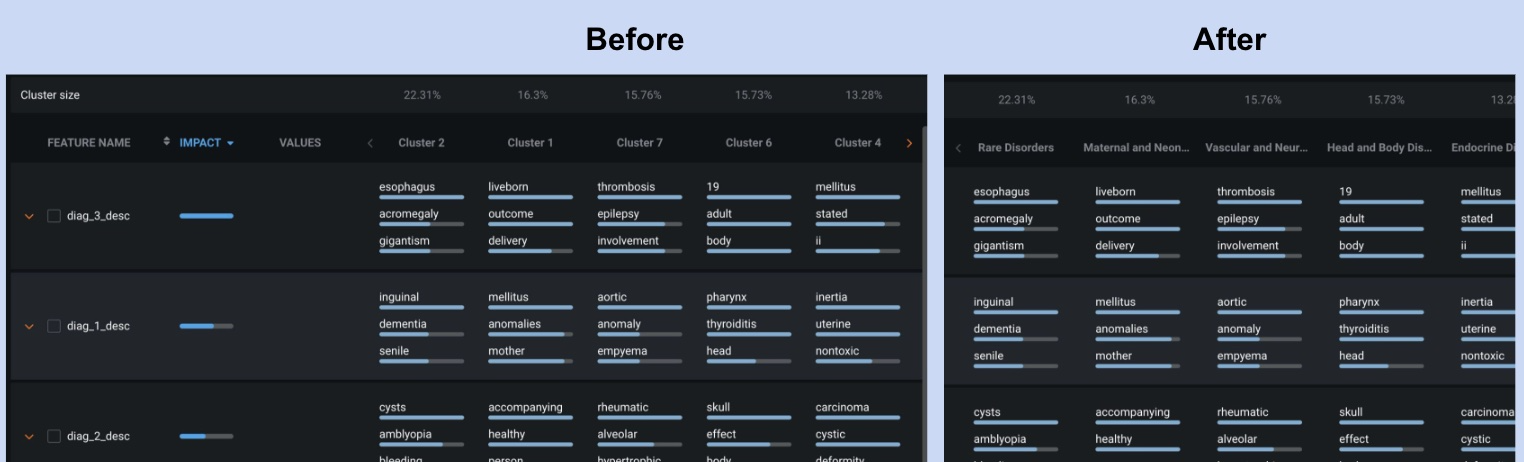

## Conclusion
This is how you can use Cluster Insights provided by DataRobot and use ChatGPT to provide business- or domain-specific labels to the clusters using OpenAI and DataRobot APIs. You also saw how you can customized the prompting to be able to tailor the cluster labels to suit the end users.